Trans_gat_graphsage

In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report
from basic_gs_sampling import multihop_sampling
from graphsage_gat_net import trans_AttnGraphSage  
from basic_gs_data import ArcData
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns


def accuracy(output, labels):
    """计算准确率"""
    _, predicted = torch.max(output, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def train(model, node_features, labels, neighbor_table, train_mask, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    src_nodes = np.where(train_mask)[0]
    sample_nums = model.num_neighbors_list
    sampled_nodes = multihop_sampling(src_nodes, sample_nums, neighbor_table)

    # 准备节点特征
    node_features_list = [node_features[sampled_nodes[hop]] for hop in range(len(sampled_nodes))]

    # 前向传播
    output = model(node_features_list)
    loss = criterion(output, labels[src_nodes])
    loss.backward()
    optimizer.step()
    return loss.item(), output, labels[src_nodes]

def test(model, node_features, labels, neighbor_table, mask, criterion):
    model.eval()
    with torch.no_grad():
        src_nodes = np.where(mask)[0]
        sample_nums = model.num_neighbors_list
        sampled_nodes = multihop_sampling(src_nodes, sample_nums, neighbor_table)
        node_features_list = [node_features[sampled_nodes[hop]] for hop in range(len(sampled_nodes))]
        output = model(node_features_list)
        loss = criterion(output, labels[src_nodes]).item()
        pred = output.argmax(dim=1)
        acc = accuracy_score(labels[src_nodes].numpy(), pred.numpy())
    return acc, loss, pred, labels[src_nodes]

def predict(model, node_features, neighbor_table, pred_mask):
    model.eval()
    with torch.no_grad():
        src_nodes = np.where(pred_mask)[0]
        sample_nums = model.num_neighbors_list
        sampled_nodes = multihop_sampling(src_nodes, sample_nums, neighbor_table)
        node_features_list = [node_features[sampled_nodes[hop]] for hop in range(len(sampled_nodes))]
        output = model(node_features_list)
        pred = output.argmax(dim=1)
    
    df = pd.DataFrame(pred, columns=["Prediction"])
    df.to_csv("pred_results.csv", index=False)
    print("预测结果已保存到 pred_results.csv")
    return pred



def compute_class_weights(labels, mask, num_classes):
    """计算每个类别的权重"""
    # 获取训练集中每个类别的样本数
    class_counts = torch.bincount(labels[mask], minlength=num_classes)
    # 计算权重：总样本数/(类别数*每个类别的样本数)
    class_weights = len(labels[mask]) / (num_classes * class_counts.float())
    # 归一化权重，使最小权重为1
    class_weights = class_weights / class_weights.min()
    return class_weights

def main():
    # 加载数据
    data_loader = ArcData()
    data = data_loader.data

    # 转换为 PyTorch 张量
    node_features = torch.tensor(data.x, dtype=torch.float32)
    labels = torch.tensor(data.y, dtype=torch.long)
    neighbor_table = data.adjacency_dict
    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask
    pred_mask = data.pred_mask

    # 统计标签分布
    def count_labels(mask, labels):
        unique, counts = torch.unique(labels[mask], return_counts=True)
        return dict(zip(unique.tolist(), counts.tolist()))

    print("训练集标签分布:", count_labels(train_mask, labels))
    print("验证集标签分布:", count_labels(val_mask, labels))
    print("测试集标签分布:", count_labels(test_mask, labels))

    # 计算类别权重
    num_classes = 6  # 有6个类别
    class_weights = compute_class_weights(labels, train_mask, num_classes)
    print("类别权重:", class_weights)
    
    # 定义模型 - 使用带注意力机制的AttnGraphSage
    input_dim = node_features.shape[1]
    model = trans_AttnGraphSage(input_dim, hidden_dim, num_neighbors_list, 
                                num_classes,aggr_method="multihead_attn",  
    heads=4,dropout=0.3)

    # 定义优化器和加权损失函数
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)  # 使用加权损失函数
    criterion = nn.CrossEntropyLoss(
        weight=class_weights,
        label_smoothing=0.1 )
    
     # 训练记录
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # 训练和验证
    for epoch in range(epochs):
        loss, train_output, train_labels = train(model, node_features, labels, neighbor_table, train_mask, optimizer, criterion)
        
        train_losses.append(loss)
        train_acc = accuracy(train_output, train_labels)
        train_accuracies.append(train_acc)
        
        val_acc, val_loss, _, _ = test(model, node_features, labels, neighbor_table, val_mask, criterion)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Train Acc:{train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    # 测试
    test_acc, _, test_pred, test_true = test(model, node_features, labels, neighbor_table, test_mask, criterion)
    print(f"Test Accuracy: {test_acc:.4f}")
    # 7️⃣ 评估模型
    print("🎯 模型准确率:", accuracy_score(test_true, test_pred))
    print("📊 分类报告:\n", classification_report(test_true, test_pred))
    
    model_save_path = "trans_gat_graphsage_finalmodel.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"✅ 模型已保存至：{model_save_path}")

    
    # ✅ 设置中文字体
    plt.rcParams['font.family'] = 'SimHei'
    plt.rcParams['axes.unicode_minus'] = False

    # 建筑类型标签
    labels = ["住宅建筑", "商业建筑", "城中村", "公共设施", "教育建筑", "仓库与工厂"]

    # 混淆矩阵
    cm = confusion_matrix(test_true, test_pred)
    
    # 绘图
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    plt.xlabel("预测标签")
    plt.ylabel("真实标签")
    plt.title("测试集混淆矩阵（建筑类型）")
    plt.tight_layout()
    plt.show()


    # 打印部分结果
    print("测试集前10个样本的预测结果和真实标签：")
    for i in range(10):
        print(f"样本 {i}: 预测结果 = {test_pred[i].item()}, 真实标签 = {test_true[i].item()}")

    # 可视化训练过程
    plt.figure(figsize=(12, 5))
    
    # 准确率曲线
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid()
    
    # 损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

混合损失：加权CE + 正则化


数据集统计:
总节点数: 924100
有标签节点: 114018 (12.3%)
  训练集: 91214 (80.0%)
  验证集: 11401 (10.0%)
  测试集: 11403 (10.0%)
预测集节点: 810082 (87.7%)
训练集标签分布: {0: 55576, 1: 7735, 2: 10226, 3: 6845, 4: 5952, 5: 4880}
验证集标签分布: {0: 6891, 1: 1045, 2: 1295, 3: 868, 4: 705, 5: 597}
测试集标签分布: {0: 6890, 1: 958, 2: 1282, 3: 893, 4: 738, 5: 642}
类别权重: tensor([ 1.0000,  7.1850,  5.4348,  8.1192,  9.3374, 11.3885])
Epoch 10, Loss: 1.7929, Train Acc:0.2432, Val Acc: 0.2728
Epoch 20, Loss: 1.7282, Train Acc:0.3278, Val Acc: 0.3729
Epoch 30, Loss: 1.6918, Train Acc:0.3592, Val Acc: 0.3986
Epoch 40, Loss: 1.6622, Train Acc:0.3845, Val Acc: 0.4336
Epoch 50, Loss: 1.6427, Train Acc:0.4094, Val Acc: 0.4503
Epoch 60, Loss: 1.6214, Train Acc:0.4469, Val Acc: 0.4762
Epoch 70, Loss: 1.6048, Train Acc:0.4689, Val Acc: 0.4899
Epoch 80, Loss: 1.5898, Train Acc:0.4820, Val Acc: 0.5221
Epoch 90, Loss: 1.5697, Train Acc:0.4850, Val Acc: 0.5461
Epoch 100, Loss: 1.5520, Train Acc:0.4938, Val Acc: 0.5550
Epoch 110, Loss: 1.5401, Train Acc:

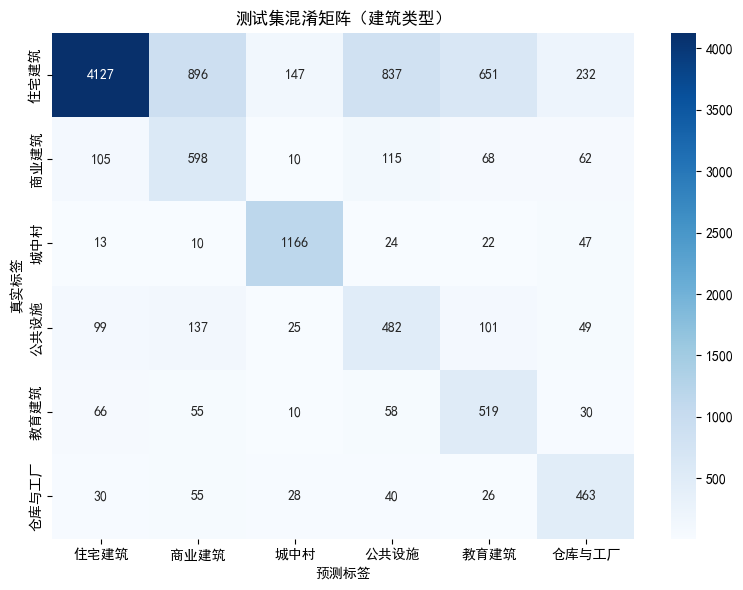

测试集前10个样本的预测结果和真实标签：
样本 0: 预测结果 = 0, 真实标签 = 0
样本 1: 预测结果 = 0, 真实标签 = 0
样本 2: 预测结果 = 0, 真实标签 = 0
样本 3: 预测结果 = 0, 真实标签 = 0
样本 4: 预测结果 = 3, 真实标签 = 3
样本 5: 预测结果 = 5, 真实标签 = 5
样本 6: 预测结果 = 1, 真实标签 = 1
样本 7: 预测结果 = 1, 真实标签 = 1
样本 8: 预测结果 = 1, 真实标签 = 1
样本 9: 预测结果 = 5, 真实标签 = 5


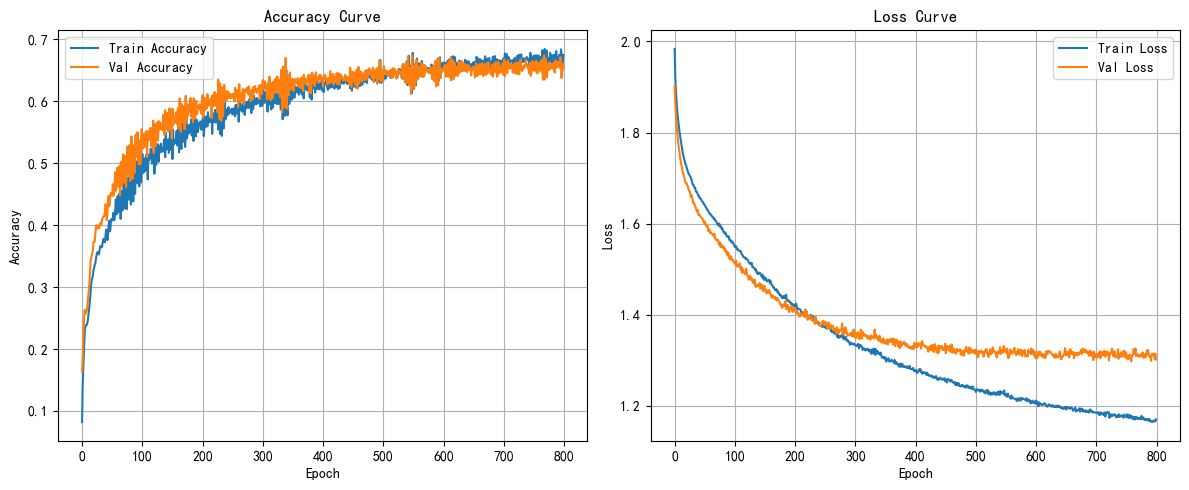

In [ ]:
# 定义模型 - 使用带注意力机制的AttnGraphSage
seed = 42
epochs = 800
hidden_dim = [512, 64]  # 隐藏层
num_neighbors_list = [3, 3]  # 每层采样的邻居数量

# 定义优化器和加权损失函数
lr=0.001
weight_decay=5e-4

if __name__ == "__main__":
    main()

用训练好的模型做预测

In [4]:
def predict_all_nodes(model, data, neighbor_table, save_path="2015_predictions.csv", batch_size=512):
    model.eval()
    all_preds = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_nodes = data.x.shape[0]
    src_nodes = np.arange(num_nodes)

    with torch.no_grad():
        for start in tqdm(range(0, num_nodes, batch_size), desc="Predicting"):
            end = min(start + batch_size, num_nodes)
            batch_src = src_nodes[start:end]

            sampled_nodes = multihop_sampling(batch_src, model.num_neighbors_list, neighbor_table)
            
            node_features_list = [
                torch.tensor(data.x[sampled_nodes[hop]], dtype=torch.float32).to(device)
                for hop in range(len(sampled_nodes))
            ]

            output = model(node_features_list)
            pred = output.argmax(dim=1).cpu().numpy()

            all_preds.extend(pred)

    df = pd.DataFrame({
        "new_id": list(data.adjacency_dict.keys()),
        "prediction": all_preds
    })
    df.to_csv(save_path, index=False)
    print(f"✅ Prediction results saved to: {save_path}")


In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report
from basic_gs_sampling import multihop_sampling
from basic_gs_data import ArcData
from graphsage_gat_net import trans_AttnGraphSage  
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [6]:
# 1. 加载数据（确保你这一步能正确执行）
data_loader = ArcData()
data = data_loader.data
# 转换为 PyTorch 张量
node_features = torch.tensor(data.x, dtype=torch.float32)
neighbor_table = data.adjacency_dict
# 2. 构建邻接表

# 3. 初始化模型结构（需和训练时保持一致）
model = trans_AttnGraphSage(
    input_dim=node_features.shape[1],
    hidden_dim = [512, 128] ,
    num_classes=6,  # 分类数
    num_neighbors_list=[3, 3]  # 训练时的设置
)

# 4. 加载训练好的模型参数
model_path = r"./trans_gat_graphsage_finalmodel2.pt"
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

# 5. 预测并保存为CSV
predict_all_nodes(model, data, neighbor_table, save_path="2015_predictions.csv", batch_size=512)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24716\3535013095.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=


数据集统计:
总节点数: 829035
有标签节点: 8 (0.0%)
  训练集: 6 (75.0%)
  验证集: 0 (0.0%)
  测试集: 2 (25.0%)
预测集节点: 829027 (100.0%)


Predicting: 100%|██████████| 1620/1620 [01:06<00:00, 24.46it/s]


✅ Prediction results saved to: 2015_predictions.csv
